# Resting state with FSLnets

This interactive demonstration is based on the official FSL course **"Resting state FSLnets practical"**.

FSLnets is a toolbox for analyzing brain network connectivity from fMRI time series, typically derived from resting-state data. It takes as input the timecourses from specific brain regions, usually obtained via group-ICA and dual regression, and computes subject-level connectivity matrices using full or partial correlations. These network matrices can then be used for statistical comparisons across subjects or groups.

**Author**: Monika Doerig

**Date**: 30 July 2025

### Citation and Resources:

#### Tools included in this workflow
__FSL/ FSLnets__:

- M. Jenkinson, C.F. Beckmann, T.E. Behrens, M.W. Woolrich, S.M. Smith. FSL. NeuroImage, 62:782-90, 2012. [https://doi.org/10.1016/j.neuroimage.2011.09.015](https://www.sciencedirect.com/science/article/pii/S1053811911010603?via%3Dihub)

  
-  Smith SM, Beckmann CF, Auerbach EJ, et al. (2013). Resting-state fMRI in the Human Connectome Project. NeuroImage, 80, 144–168. [https://doi.org/10.1016/j.neuroimage.2013.05.039](https://www.sciencedirect.com/science/article/pii/S1053811913005338?via%3Dihub)


#### Educational resources
- [FSL course online materials](https://open.win.ox.ac.uk/pages/fslcourse/website/online_materials.html)
- [FSL course practicals FSLnets](https://open.win.ox.ac.uk/pages/fslcourse/practicals/fslnets/index.html)
- [FSL Wiki fslnets](https://fsl.fmrib.ox.ac.uk/fsl/docs/#/resting_state/fslnets)

#### Dataset
- [Link to Downloading and Installing FSL Course Data](https://open.win.ox.ac.uk/pages/fslcourse/website/downloads.html)

## Introduction to FSLnets
FSLnets enables network modeling of fMRI data by analyzing the temporal relationships between brain regions. It is particularly useful for group-level studies of functional connectivity, where the goal is to identify differences or commonalities in brain network organization

__The typical FSLnets pipeline includes:__
- Extracting subject-level timeseries spatial node maps (e.g., dual regression outputs)
- Identifying and removing structured noise components from the data
- Computing full or partial correlation matrices (netmats) for each subject
- Exploring group-average connectivity patterns and hierarchical node clustering
- Performing statistical comparisons of connectivity across subjects or group
- *(Optional)* Conducting multivariate cross-subject analysis, which uses the full network matrix to classify or differentiate groups (e.g., patients vs. controls) using machine learning techniques like linear discriminant analysis (LDA), support vector machines (SVM), or random forests

This notebook guides you through the core steps of network analysis: estimating connectivity matrices, comparing them across groups, and visualizing the results.

For a full pipeline and detailed information about the steps, refer to the complete [Resting state FSLnets practical](https://open.win.ox.ac.uk/pages/fslcourse/practicals/fslnets/index.html).

## Load FSL and Import Python libraries

In [1]:
import module
await module.load('fsl/6.0.7.16')
await module.list()

['fsl/6.0.7.16']

In [2]:
import subprocess
from IPython.display import Image, Markdown
import numpy as np

## Download course material

In [3]:
!wget -c -nc https://fsl.fmrib.ox.ac.uk/fslcourse/downloads/rest.tar.gz
!tar -xzvf rest.tar.gz --wildcards --no-anchored 'rest/Nets/*'
!rm -r rest.tar.gz

--2025-11-03 00:15:23--  https://fsl.fmrib.ox.ac.uk/fslcourse/downloads/rest.tar.gz
Resolving fsl.fmrib.ox.ac.uk (fsl.fmrib.ox.ac.uk)... 129.67.248.66
Connecting to fsl.fmrib.ox.ac.uk (fsl.fmrib.ox.ac.uk)|129.67.248.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15935669577 (15G) [application/x-gzip]
Saving to: ‘rest.tar.gz’

rest.tar.gz         100%[===================>]  14.84G  40.8MB/s    in 4m 35s  

2025-11-03 00:19:59 (55.2 MB/s) - ‘rest.tar.gz’ saved [15935669577/15935669577]

fsl_course_data/rest/Nets/groupICA100/
fsl_course_data/rest/Nets/groupICA100/Noise__inv.nii.gz
fsl_course_data/rest/Nets/groupICA100/mask.nii.gz
fsl_course_data/rest/Nets/groupICA100/melodic_pca.nii.gz
fsl_course_data/rest/Nets/groupICA100/report/
fsl_course_data/rest/Nets/groupICA100/report/IC_76_prob.png
fsl_course_data/rest/Nets/groupICA100/report/IC_90_thresh.png
fsl_course_data/rest/Nets/groupICA100/report/IC_49_MMfit.png
fsl_course_data/rest/Nets/groupICA100/report/IC_1

### FSLnets Network Analysis Setup
Technical Note: FSLnets is typically executed using the `fslipython` command in a terminal, which provides access to FSL's Python environment with all necessary dependencies. Since Jupyter notebooks can't directly invoke `fslipython` commands,  this demo creates standalone Python scripts (using `%%writefile`) containing the FSLnets code and runs them externally using subprocess calls within the following utility function:

In [4]:
import os
#create output directory
os.makedirs("FSLnets", exist_ok=True)

In [5]:
# Utility function to run fslpython scripts safely in Jupyter

def run_fslpython(script_path, verbose=True):
    """
    Run a Python script using fslpython inside a Jupyter notebook.
    Prevents hanging by disabling stdin and capturing output.

    Parameters
    ----------
    script_path : str
        Path to the Python script to run with fslpython.

    """
    result = subprocess.run(
        ["fslpython", script_path],
        stdin=subprocess.DEVNULL,      # prevent it from waiting for input
        capture_output=True,           # capture stdout and stderr
        text=True                      # decode bytes to string
    )

    if verbose or result.stderr:
        if result.stdout:
            print("✅ STDOUT:\n", result.stdout)
        if result.stderr:
            print("⚠️ STDERR:\n", result.stderr)
            
    # No return statement

## Networks estimation

__Loading Data:__

FSLnets loads timeseries data with `nets.load()`from dual-regression output into a `ts` object containing multiple fields for network analysis.

__Quality Controland Cleaning Components:__
- Spectral Analysis: `nets.plot_spectra(ts)` visualizes temporal spectra of resting-state networks to verify data quality
- Component Cleanup: Remove artifact components using `nets.clean()` with predefined good nodes based on spatial maps, timeseries, and frequency spectra.

__Network Matrix Calculation (netmats):__
Two types of connectivity matrices are computed for each subject:
- Full Correlation (`corr`): Simple correlation coefficients between all node pairs
- Partial Correlation (`ridgep`): Regularized partial correlations that better estimate direct connections by removing indirect effects

→ Partial correlation matrices typically provide more accurate representations of direct network connections compared to full correlation matrices.

In [6]:
%%writefile ./FSLnets/estimate_network.py

import matplotlib.pyplot as plt
from fsl import nets
import numpy as np
import pickle

# Load the ICA time series
ts = nets.load('./fsl_course_data/rest/Nets/groupICA100.dr',
               tr=0.72,
               varnorm=0,
               thumbnaildir='./fsl_course_data/rest/Nets/groupICA100.sum')

print("📘 Help on ts.ts:")
help(ts.ts)

# Plot original spectra
nets.plot_spectra(ts)
plt.savefig('./FSLnets/temporal_spectra_of_RSNs.png')
plt.close()

# Clean the time series using selected nodes
goodnodes = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11,
             12, 16, 17, 18, 19, 20, 21, 22, 24, 25,
             26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
             36, 37, 39, 41, 42, 46, 47, 48, 49, 51,
             52, 54, 55, 56, 57, 58, 60, 61, 63, 64,
             65, 69, 70, 71, 72, 73, 76, 79, 80, 85,
             86, 92, 96]

nets.clean(ts, goodnodes, aggressive=True) # aggressive cleanup

with open('./FSLnets/ts_cleaned.pkl', 'wb') as f:
    pickle.dump(ts, f)

# Plot cleaned spectra
nets.plot_spectra(ts)
plt.savefig('./FSLnets/cleaned_spectra.png')
plt.close()

# Compute full and partial correlation matrices
Fnetmats = nets.netmats(ts, method='corr')
Pnetmats = nets.netmats(ts, method='ridgep')

# Save netmats as NumPy arrays for inspection
np.save('./FSLnets/Fnetmats.npy', Fnetmats)
np.save('./FSLnets/Pnetmats.npy', Pnetmats)

print("Fnetmats shape:", Fnetmats.shape) # number of rows is equal to the number of subjects
print("Pnetmats shape:", Pnetmats.shape)

print("✅ Finished computing and saving results.")

Overwriting ./FSLnets/estimate_network.py


In [7]:
run_fslpython('./FSLnets/estimate_network.py')

✅ STDOUT:
 📘 Help on ts.ts:
Help on list object:

class list(object)
 |  list(iterable=(), /)
 |
 |  Built-in mutable sequence.
 |
 |  If no argument is given, the constructor creates a new empty list.
 |  The argument must be an iterable if specified.
 |
 |  Methods defined here:
 |
 |  __add__(self, value, /)
 |      Return self+value.
 |
 |  __contains__(self, key, /)
 |      Return bool(key in self).
 |
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |
 |  __eq__(self, value, /)
 |      Return self==value.
 |
 |  __ge__(self, value, /)
 |      Return self>=value.
 |
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |
 |  __getitem__(self, index, /)
 |      Return self[index].
 |
 |  __gt__(self, value, /)
 |      Return self>value.
 |
 |  __iadd__(self, value, /)
 |      Implement self+=value.
 |
 |  __imul__(self, value, /)
 |      Implement self*=value.
 |
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for acc

#### Node time series power spectra

The top section of the plot displays the average power spectrum for each group-ICA component across all subjects. The bottom section shows all spectra overlaid, with the median spectrum highlighted as a thick black line.

Ideally, spectra should decline smoothly at higher frequencies. Components with elevated power in the mid to high frequency range (a "raised tail") may indicate noise. The median spectrum also appears as a thin grey line behind each individual plot on the left.

#### Original spectra

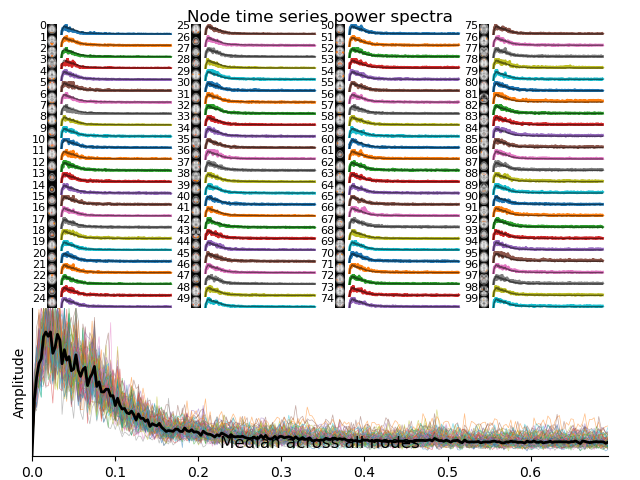

In [8]:
display(Markdown('#### Original spectra'), Image('./FSLnets/temporal_spectra_of_RSNs.png'))

#### Cleaned spectra

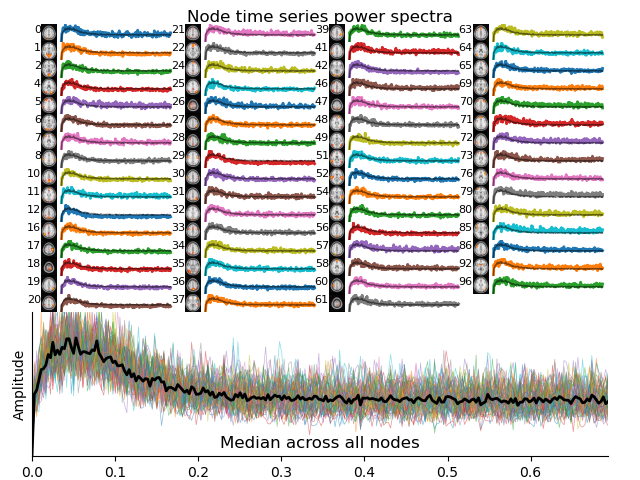

In [9]:
display(Markdown('#### Cleaned spectra'), (Image('./FSLnets/cleaned_spectra.png')))

## Group-average netmat summaries

The following script performs group-level statistical analysis on the individual subject network matrices computed previously. It calculates group averages and statistical significance across all subjects using `nets.groupmean()`, which produces both simple averages (`Mnet`) and one-sample t-test results (`Znet`) testing connectivity strength against zero.

The analysis generates two key visualizations: a summary figure showing group t-test results alongside a consistency scatter plot (indicating how similar individual subjects are to the group average), and a network hierarchy plot that reveals how individual nodes cluster into larger resting-state networks through hierarchical clustering based on covariance patterns.

The script also demonstrates how to access specific connectivity values (e.g., Mnet_P[2, 26]) and map them back to original component indices using `ts.nodes`, accounting for the fact that node numbering changes after artifact removal during the cleaning step.

*This analysis reveals group-level connectivity patterns and network organization, including identification of well-known resting-state networks like the default mode network.*

In [10]:
%%writefile ./FSLnets/nets_group_analysis.py

import matplotlib.pyplot as plt
from fsl import nets
import numpy as np
import pickle

Fnetmats = np.load('./FSLnets/Fnetmats.npy')
Pnetmats = np.load('./FSLnets/Pnetmats.npy')

with open('./FSLnets/ts_cleaned.pkl', 'rb') as f:
    ts = pickle.load(f)

# === Group-level analysis ===
Znet_F, Mnet_F = nets.groupmean(ts, Fnetmats, plot=False)
Znet_P, Mnet_P = nets.groupmean(ts, Pnetmats, plot=True, title='Partial correlation')
plt.savefig('./FSLnets/groupmean_partial_corr.png', dpi=300, bbox_inches='tight')
plt.close()
print("📊 Summary figure plot saved as 'groupmean_partial_corr.png'")

# Save matrices
np.save('./FSLnets/Znet_F.npy', Znet_F)
np.save('./FSLnets/Znet_P.npy', Znet_P)
np.save('./FSLnets/Mnet_F.npy', Mnet_F)
np.save('./FSLnets/Mnet_P.npy', Mnet_P)

# Print a specific matrix entry as requested
print("✅ Group means calculated.")
print("Mnet_P[2, 26] =", Mnet_P[2, 26])
print("Original node indices for row 3 and column 27:")
print("ts.nodes[2] =", ts.nodes[2])
print("ts.nodes[26] =", ts.nodes[26])

# === Network hierarchy visualization ===
nets.plot_hierarchy(ts, Znet_F, Znet_P, lowlabel='Full correlations', highlabel='Partial correlations')
plt.savefig('./FSLnets/network_hierarchy.png')
plt.close()

print("📊 Network hierarchy plot saved as 'network_hierarchy.png'")

Overwriting ./FSLnets/nets_group_analysis.py


In [11]:
run_fslpython('./FSLnets/nets_group_analysis.py')

✅ STDOUT:
 📊 Summary figure plot saved as 'groupmean_partial_corr.png'
✅ Group means calculated.
Mnet_P[2, 26] = 6.654220574631274
Original node indices for row 3 and column 27:
ts.nodes[2] = 2
ts.nodes[26] = 32
📊 Network hierarchy plot saved as 'network_hierarchy.png'

⚠️ STDERR:
 invalid value encountered in divide



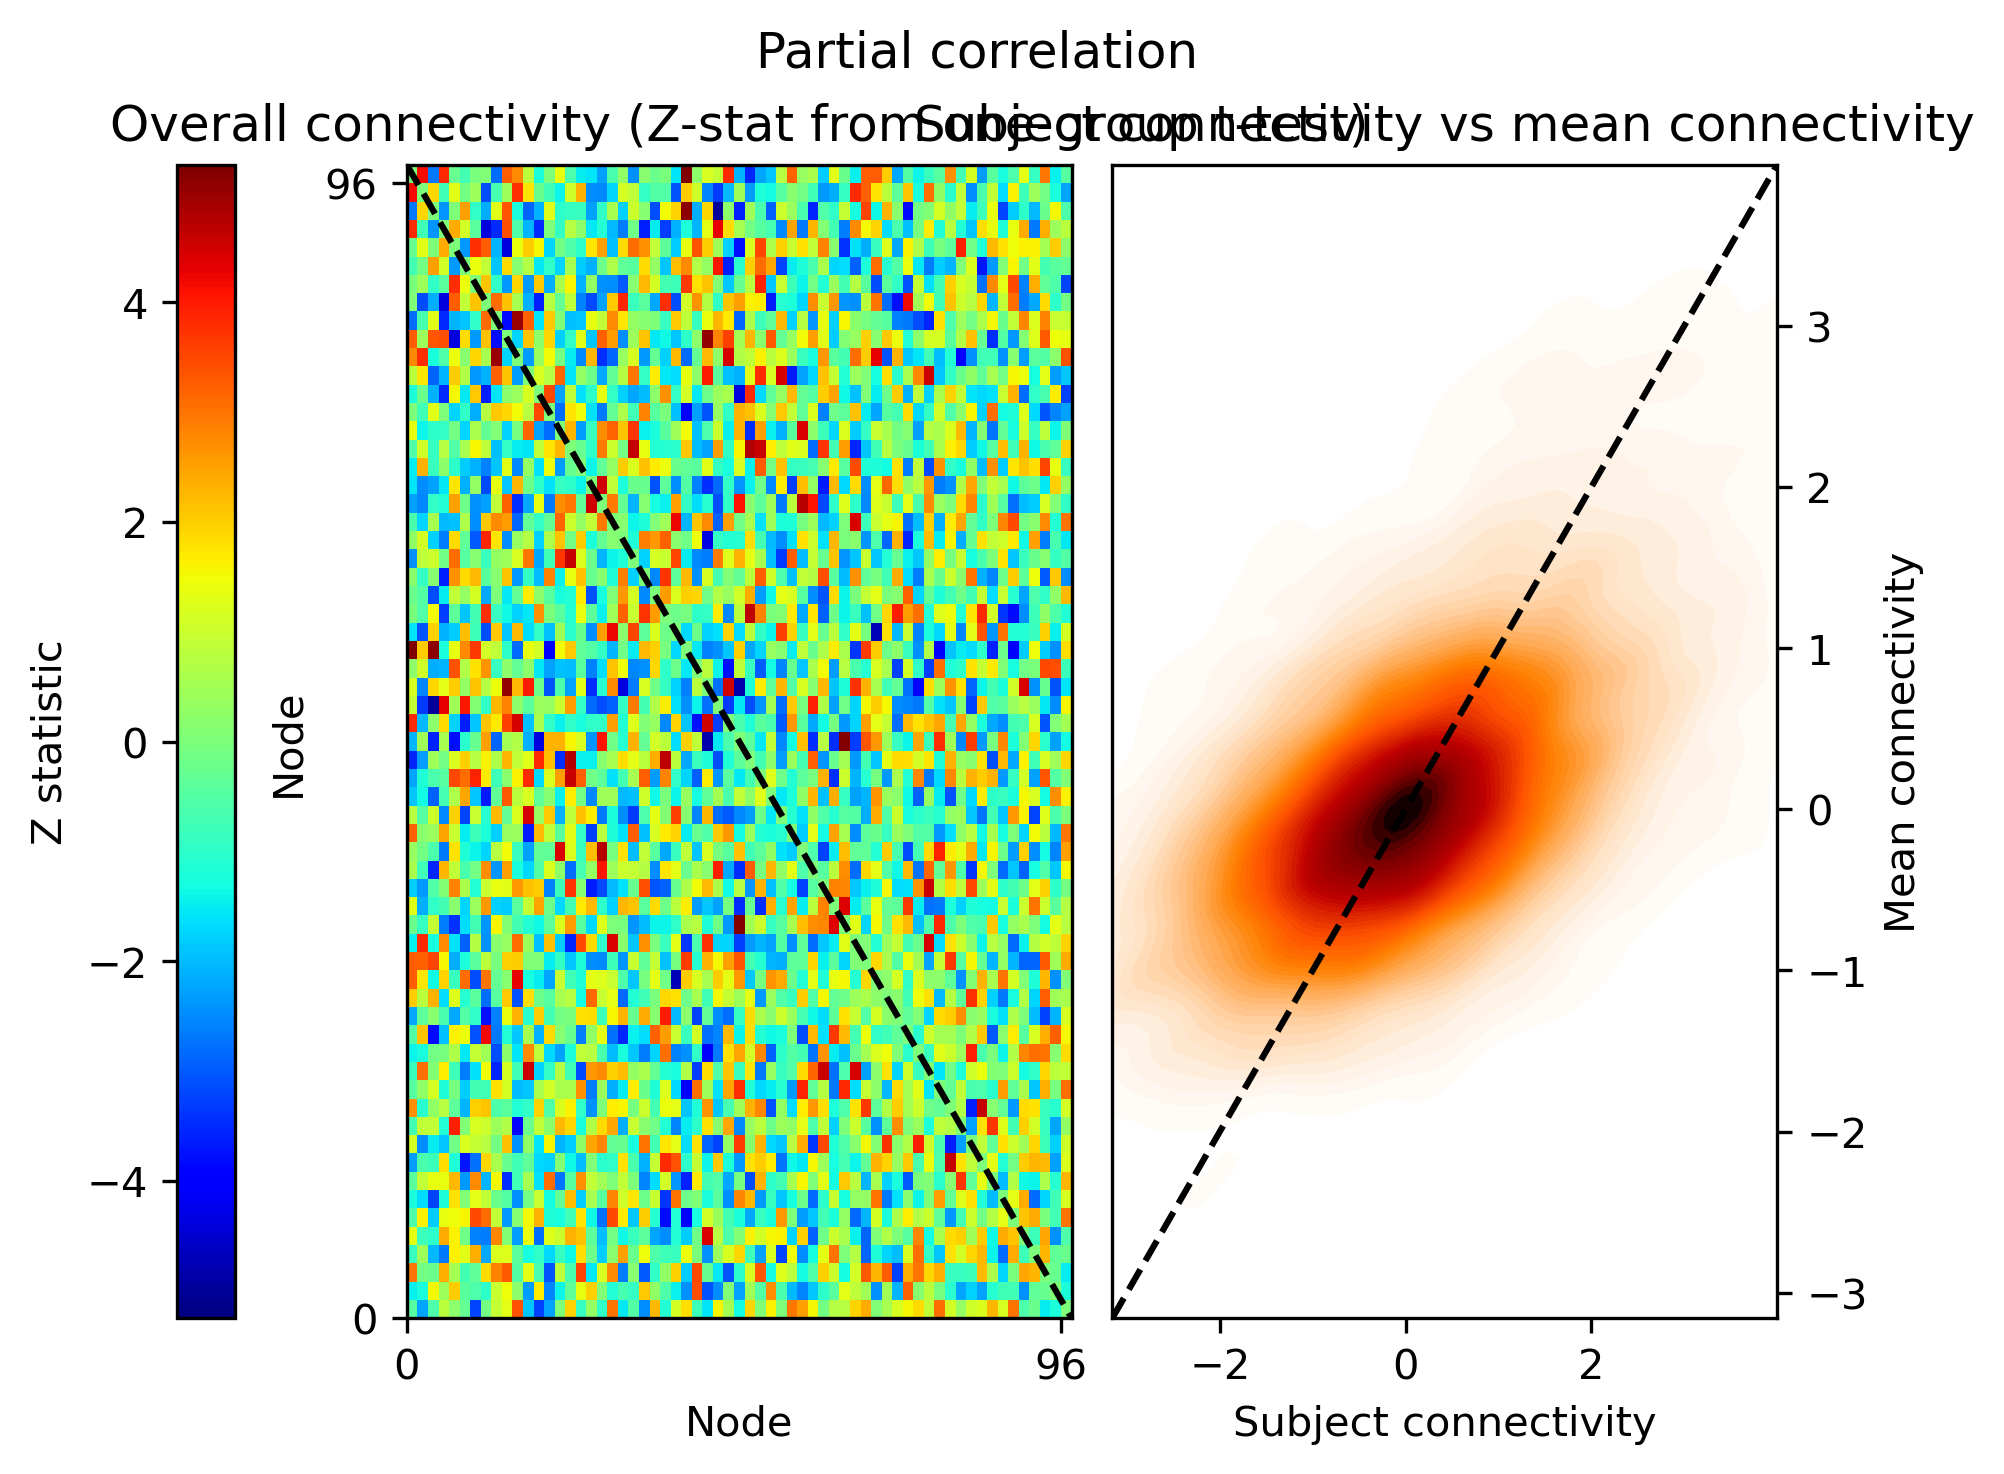

In [12]:
display(Image('./FSLnets/groupmean_partial_corr.png'))

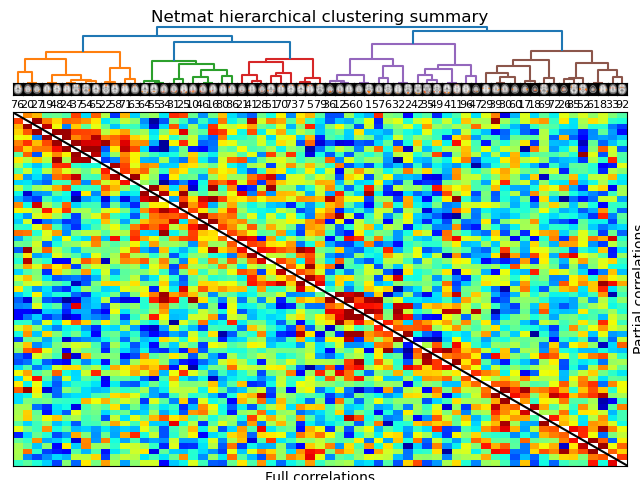

In [13]:
display(Image('./FSLnets/network_hierarchy.png'))

## Cross-subject comparison with netmats
This script performs statistical comparison between two groups (healthy controls vs. tumor patients) using the partial correlation network matrices. It implements a two-sample t-test with permutation testing via FSL's randomise function, treating each network connection as a separate statistical test while correcting for multiple comparisons across all edges.

The analysis uses pre-designed GLM files to compare connectivity patterns between groups with 5000 permutations per contrast. Results are visualized in two ways: a network matrix showing corrected p-values for significant group differences (p<0.05), and detailed boxplots displaying the strongest between-group differences for specific node pairs. The boxplot visualization reveals which specific brain network connections differ most significantly between groups, with connection strength indicated by line thickness and color (red=positive correlation, blue=negative/anti-correlation), and statistical significance shown as 1-p values (values >0.95 indicate significant differences after multiple comparison correction).

*This analysis identifies specific network connections that are disrupted in tumor patients compared to healthy controls, providing insights into disease-related changes in brain connectivity.*

In [14]:
%%writefile ./FSLnets/cross_subject_comparison.py

import pickle
import numpy as np
from fsl import nets
import matplotlib.pyplot as plt

# Load cleaned timeseries and partial correlation netmats
with open('./FSLnets/ts_cleaned.pkl', 'rb') as f:
    ts = pickle.load(f)

#with open('Pnetmats.pkl', 'rb') as f:
#    Pnetmats = pickle.load(f)
Pnetmats = np.load('./FSLnets/Pnetmats.npy')
Znet_P = np.load('./FSLnets/Znet_P.npy')


# Perform two-sample t-test using randomise
p_corr, p_uncorr = nets.glm(
    ts,
    Pnetmats,
    './fsl_course_data/rest/Nets/design/unpaired_ttest_1con.mat',
    './fsl_course_data/rest/Nets/design/unpaired_ttest_1con.con'
)
plt.savefig('./FSLnets/corrected_pvalues.png')
plt.close()

# Save p-values to file for later reuse
with open('./FSLnets/p_corr.pkl', 'wb') as f:
    pickle.dump(p_corr, f)

with open('./FSLnets/p_uncorr.pkl', 'wb') as f:
    pickle.dump(p_uncorr, f)

# Visualize group differences using boxplots
nets.boxplots(ts, Pnetmats, Znet_P, p_corr[0], groups=(6, 6))
plt.savefig('./FSLnets/significant_group_differences.png')
plt.close()

print("✅ Two-sample t-test complete and plots generated.")


Overwriting ./FSLnets/cross_subject_comparison.py


In [15]:
run_fslpython('./FSLnets/cross_subject_comparison.py')

✅ STDOUT:
 1799233

-----------------
Contrast 1 [1 -1]
-----------------

Node i | Node j | T statistic | P value  
------ | ------ | ----------- | ---------
39     | 76     | 7.6404834   | 0.9751082
✅ Two-sample t-test complete and plots generated.



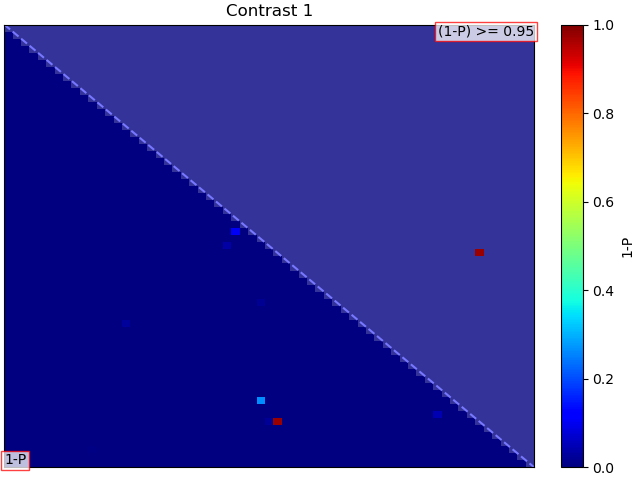

In [16]:
display(Image('./FSLnets/corrected_pvalues.png'))

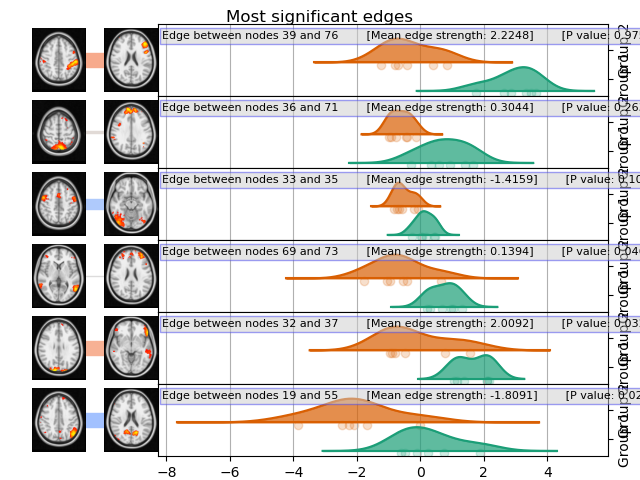

In [17]:
display(Image('./FSLnets/significant_group_differences.png'))

### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [18]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-11-03T00:27:39.337183+00:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

IPython: 8.16.1
numpy  : 2.2.6

